<a href="https://colab.research.google.com/github/HansDampf37/Kaggle/blob/main/Kaggle_Titanic_Survival_Prediction_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [112]:
!pip install shap
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [113]:
labeled = pd.read_csv('data/train.csv')
unlabeled = pd.read_csv('data/test.csv')
labeled.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [114]:
def preprocess_data(data):
  data['CabinLetter'] = data['Cabin'].str.extract(r'([A-Za-z])', expand=False)
  data['CabinNumber'] = data['Cabin'].str.extract(r'(\d+)', expand=False)
  data['Title'] = data['Name'].apply(extract_title)

  data['Age'].fillna(data['Age'].median(), inplace=True)
  data['Fare'].fillna(data['Fare'].median(), inplace=True)
  data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)

  data['TicketPrefix'] = data['Ticket'].apply(lambda x: x.split()[0] if len(x.split()) > 1 else None)
  data['TicketNumber'] = data['Ticket'].apply(lambda x: x.split()[-1])

  data['CabinLetter'] = pd.factorize(data['CabinLetter'])[0]
  data['CabinNumber'] = pd.to_numeric(data['CabinNumber'], errors='coerce')
  data['Sex'] = pd.factorize(data['Sex'])[0]
  data['Title'] = pd.factorize(data['Title'])[0]
  data['TicketPrefix'] = pd.factorize(data['TicketPrefix'])[0]
  data['TicketNumber'] = pd.to_numeric(data['TicketNumber'], errors='coerce')
  data['Embarked'] = pd.factorize(data['Embarked'])[0]
  data.fillna(-1, inplace=True)
  data.drop(columns=['Name', 'Cabin', 'Ticket', 'PassengerId'], inplace=True)

def extract_title(name):
    title = name.split(',')[1].split('.')[0].strip()
    return title

y = labeled['Survived']
X = labeled.drop(columns=["Survived"])
preprocess_data(X)
passengerIds = unlabeled['PassengerId']
preprocess_data(unlabeled)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print(f"Train size: {X_train.shape[0]}")
print(f"Test size: {X_test.shape[0]}")

X.head()

Train size: 801
Test size: 90


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,CabinLetter,CabinNumber,Title,TicketPrefix,TicketNumber
0,3,0,22.0,1,0,7.2500,0,-1,-1.0,0,0,21171.0
1,1,1,38.0,1,0,71.2833,1,0,85.0,1,1,17599.0
2,3,1,26.0,0,0,7.9250,0,-1,-1.0,2,2,3101282.0
3,1,1,35.0,1,0,53.1000,0,0,123.0,1,-1,113803.0
4,3,0,35.0,0,0,8.0500,0,-1,-1.0,0,-1,373450.0


In [140]:
class FFN(nn.Module):
  def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size, dropout_prob=0.5, l2_lambda=0.01):
    super(FFN, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size1)
    self.fc2 = nn.Linear(hidden_size1, hidden_size2)
    self.fc3 = nn.Linear(hidden_size2, hidden_size3)
    self.fc4 = nn.Linear(hidden_size3, output_size)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(dropout_prob)
    self.loss_fn = nn.CrossEntropyLoss()
    self.optimizer = optim.Adam(self.parameters(), lr=0.001, weight_decay=l2_lambda)

  def forward(self, x):
    x = self.fc1(x)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.fc2(x)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.fc3(x)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.fc4(x)
    return x

  def fit(self, train, labels, batch_size, epochs):
    self.train()
    train = torch.tensor(train.values, dtype=torch.float32)
    labels = torch.tensor(labels.values, dtype=torch.long)
    train_dataset = TensorDataset(train, labels)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    for epoch in range(epochs):
      for data, target in train_loader:
        self.optimizer.zero_grad()
        output = self(data)
        loss = self.loss_fn(output, target)
        loss.backward()
        self.optimizer.step()
    print("Finished training")

  def score(self, test, labels):
    self.eval()
    test = torch.tensor(test.values, dtype=torch.float32)
    labels = torch.tensor(labels.values, dtype=torch.long)
    with torch.no_grad():
      output = self(test)
      _, predicted = torch.max(output.data, 1)
      total = labels.size(0)
      correct = (predicted == labels).sum().item()
      return correct / total

In [152]:
m1_cols = ['Pclass', 'CabinNumber', 'CabinLetter', 'Embarked', 'TicketPrefix', 'TicketNumber']
m2_cols = ['SibSp', 'Parch', 'Age', 'Sex', 'Title']
m3_cols = ['Age', 'Sex', 'Pclass', 'Fare', 'Title']
m4_cols = X.columns.tolist()
main_cols = ['Age', 'Sex', 'Pclass', 'Fare', 'SibSp', 'Parch']

cols_list = [m1_cols, m2_cols, m3_cols, m4_cols]
indices = [[X.columns.get_loc(col) for col in cols] for cols in cols_list]

X_train_m1 = X_train[m1_cols]
X_train_m2 = X_train[m2_cols]
X_train_m3 = X_train[m3_cols]
X_train_m4 = X_train[m4_cols]
X_train_main = X_train[main_cols]

X_test_m1 = X_test[m1_cols]
X_test_m2 = X_test[m2_cols]
X_test_m3 = X_test[m3_cols]
X_test_m4 = X_test[m4_cols]
X_test_main = X_test[main_cols]

rfc_1 = RandomForestClassifier(n_estimators=100, random_state=42)
rfc_2 = RandomForestClassifier(n_estimators=100, random_state=42)
rfc_3 = RandomForestClassifier(n_estimators=100, random_state=42)
rfc_4 = RandomForestClassifier(n_estimators=100, random_state=42)
rfc_1.fit(X_train_m1, y_train)
rfc_2.fit(X_train_m2, y_train)
rfc_3.fit(X_train_m3, y_train)
rfc_4.fit(X_train_m4, y_train)

svc_1 = SVC(random_state=43)
svc_2 = SVC(random_state=43)
svc_3 = SVC(random_state=43)
svc_4 = SVC(random_state=43)
svc_1.fit(X_train_m1, y_train)
svc_2.fit(X_train_m2, y_train)
svc_3.fit(X_train_m3, y_train)
svc_4.fit(X_train_m4, y_train)

ff_1 = FFN(len(m1_cols), 32, 32, 32, 2)
ff_2 = FFN(len(m2_cols), 32, 32, 32, 2)
ff_3 = FFN(len(m3_cols), 32, 32, 32, 2)
ff_4 = FFN(len(main_cols), 32, 64, 64, 2)
ff_1.fit(X_train_m1, y_train, 32, 600)
ff_2.fit(X_train_m2, y_train, 32, 600)
ff_3.fit(X_train_m3, y_train, 32, 600)
ff_4.fit(X_train_main, y_train, 32, 600)

print(f"FFN testing:    {ff_1.score(X_test_m1, y_test), ff_2.score(X_test_m2, y_test), ff_3.score(X_test_m3, y_test), ff_4.score(X_test_main, y_test)}")
print(f"FFN training:   {ff_1.score(X_train_m1, y_train), ff_2.score(X_train_m2, y_train), ff_3.score(X_train_m3, y_train), ff_4.score(X_train_main, y_train)}")
print(f"Random Forests: {rfc_1.score(X_test_m1, y_test), rfc_2.score(X_test_m2, y_test), rfc_3.score(X_test_m3, y_test), rfc_4.score(X_test_m4, y_test)}")
print(f"Support Vector Machines: {svc_1.score(X_test_m1, y_test), svc_2.score(X_test_m2, y_test), svc_3.score(X_test_m3, y_test), svc_4.score(X_test_m4, y_test)}")

Finished training
Finished training
Finished training
Finished training
FFN testing:    (0.6, 0.8, 0.8222222222222222, 0.7888888888888889)
FFN training:   (0.6179775280898876, 0.8177278401997503, 0.7752808988764045, 0.7865168539325843)
Random Forests: (0.6888888888888889, 0.8, 0.8, 0.8666666666666667)
Support Vector Machines: (0.6, 0.6, 0.6888888888888889, 0.6)


In [116]:
explainer1 = shap.TreeExplainer(rfc_1, X_train_m1[0:50])
shap_values1 = explainer1(X_train_m1[0:50])
explainer2 = shap.TreeExplainer(rfc_2, X_train_m2[0:50])
shap_values2 = explainer2(X_train_m2[0:50])
explainer3 = shap.TreeExplainer(rfc_3, X_train_m3[0:50])
shap_values3 = explainer3(X_train_m3[0:50])
explainer4 = shap.TreeExplainer(rfc_4, X_train_m4[0:50])
shap_values4 = explainer4(X_train_m4[0:50])

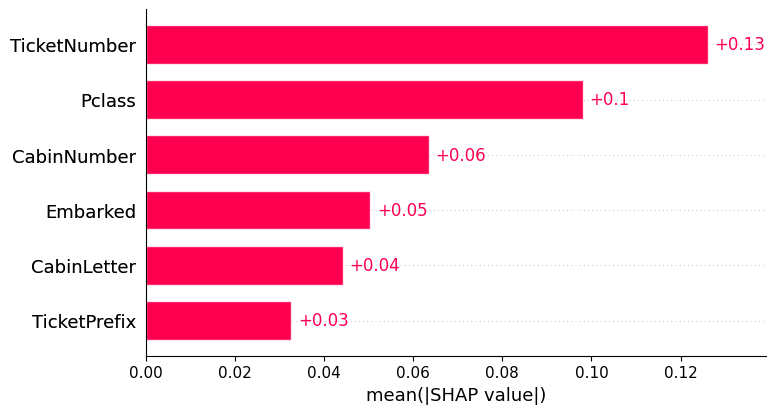

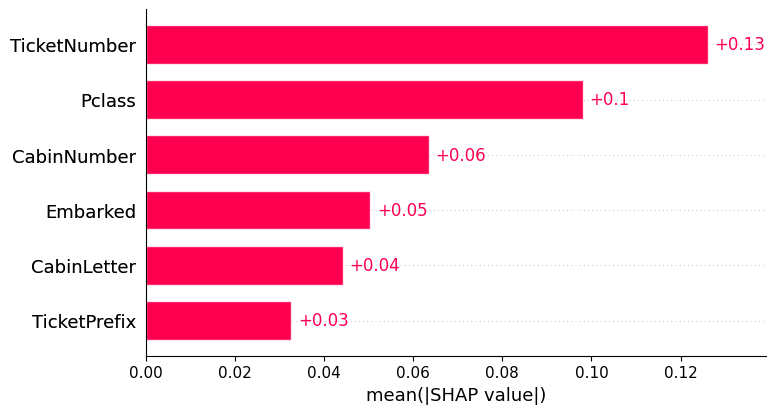

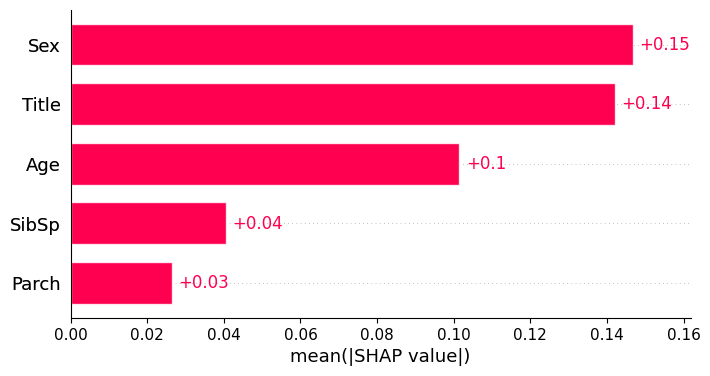

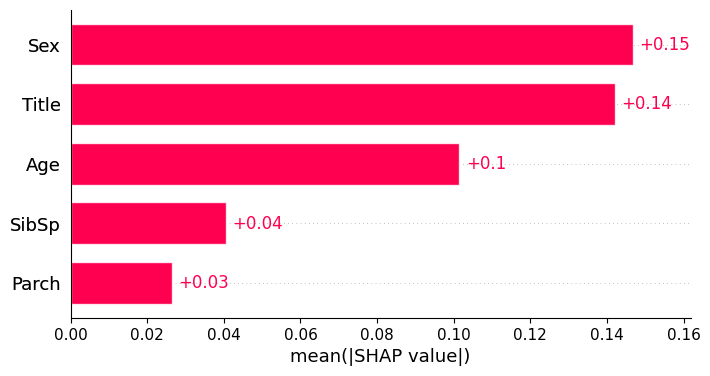

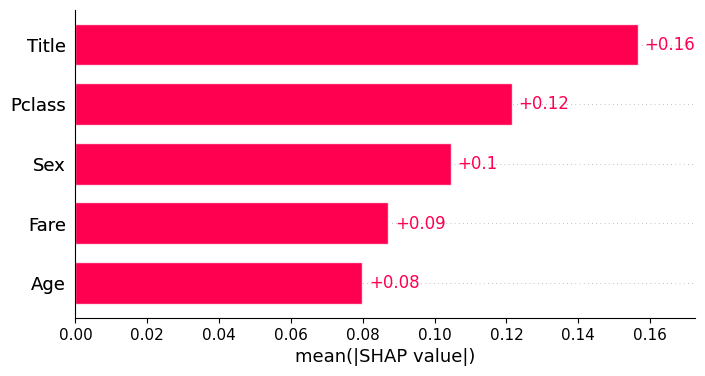

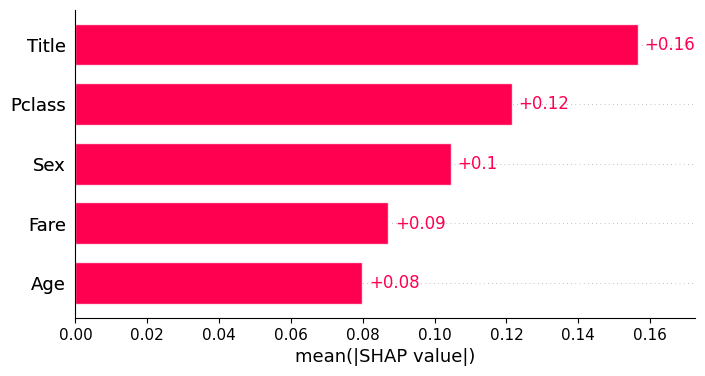

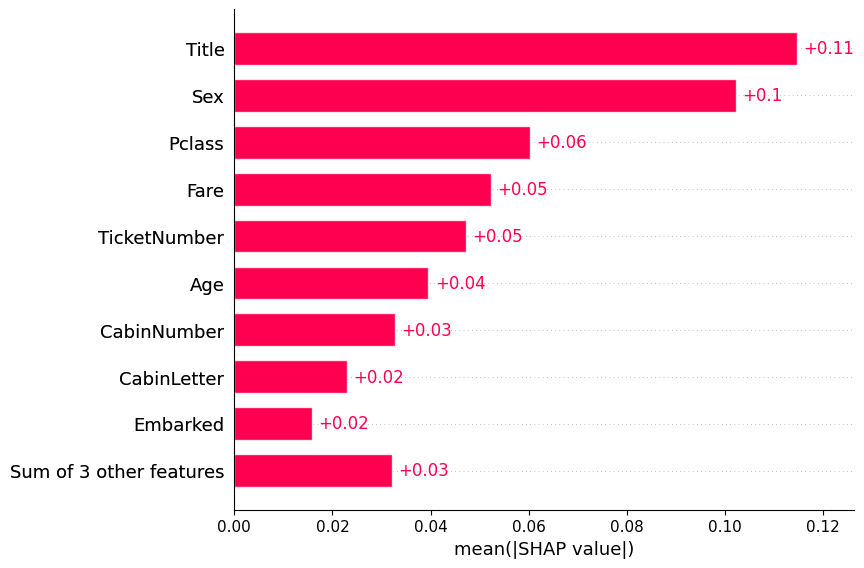

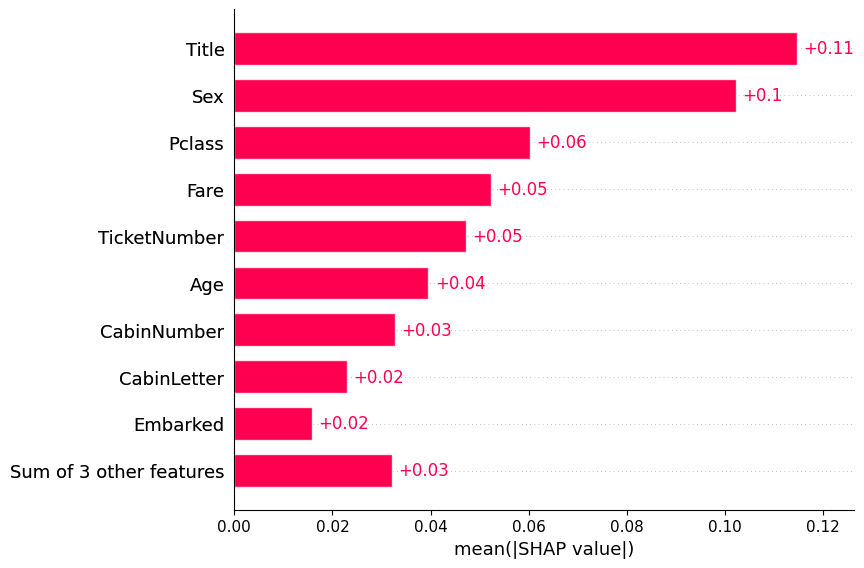

<Figure size 640x480 with 0 Axes>

In [117]:
shap.plots.bar(shap_values1[:,:,0])
shap.plots.bar(shap_values1[:,:,1])

shap.plots.bar(shap_values2[:,:,0])
shap.plots.bar(shap_values2[:,:,1])

shap.plots.bar(shap_values3[:,:,0])
shap.plots.bar(shap_values3[:,:,1])

shap.plots.bar(shap_values4[:,:,0])
shap.plots.bar(shap_values4[:,:,1])


plt.tight_layout()
plt.show()

In [118]:
class EnsembleModel(nn.Module):
  def __init__(self, models, indices, dropout_prob = 0.5, l2_lambda=0.01):
    super(EnsembleModel, self).__init__()
    self.models = models
    self.indices = indices
    self.factors = nn.ParameterList([nn.Parameter(torch.randn(1, 2)) for _ in range(len(models))])
    self.dropout = nn.Dropout(dropout_prob)
    self.loss_fn = nn.CrossEntropyLoss()
    self.optimizer = optim.Adam(self.parameters(), lr=0.001, weight_decay=l2_lambda)

  def forward(self, x):
    model_predictions = []
    for model, idx in zip(self.models, self.indices):
      x_subset = x[:, idx]
      x_subset_df = pd.DataFrame(x_subset.numpy(), columns=[X.columns[i] for i in idx])
      pred = torch.tensor(model.predict_proba(x_subset_df), dtype=torch.float32)
      pred = self.dropout(pred) # Apply dropout to each model's prediction
      model_predictions.append(pred)

    weighted_predictions = []
    for pred, factor in zip(model_predictions, self.factors):
      weighted_predictions.append(pred * factor)

    sum_factors = sum([factor for factor in self.factors])
    # Sum the weighted predictions and normalize
    return sum(weighted_predictions) / sum_factors

ensemble_model = EnsembleModel([rfc_1, rfc_2, rfc_3, rfc_4], indices)

Train Epoch: 0 Loss: 14.86, train-acc: 88.64, test-acc: 83.33
Train Epoch: 1 Loss: 15.42, train-acc: 89.26, test-acc: 83.33
Train Epoch: 2 Loss: 13.83, train-acc: 90.01, test-acc: 83.33
Train Epoch: 3 Loss: 13.75, train-acc: 90.26, test-acc: 83.33
Train Epoch: 4 Loss: 14.28, train-acc: 90.39, test-acc: 83.33
Train Epoch: 5 Loss: 13.28, train-acc: 90.51, test-acc: 82.22
Train Epoch: 6 Loss: 13.49, train-acc: 90.64, test-acc: 82.22
Train Epoch: 7 Loss: 12.52, train-acc: 91.51, test-acc: 82.22
Train Epoch: 8 Loss: 13.52, train-acc: 91.51, test-acc: 82.22
Train Epoch: 9 Loss: 12.50, train-acc: 91.89, test-acc: 82.22
Train Epoch: 10 Loss: 13.43, train-acc: 91.89, test-acc: 81.11
Train Epoch: 11 Loss: 12.95, train-acc: 91.89, test-acc: 81.11
Train Epoch: 12 Loss: 13.23, train-acc: 92.63, test-acc: 81.11
Train Epoch: 13 Loss: 12.71, train-acc: 92.76, test-acc: 81.11
Train Epoch: 14 Loss: 12.27, train-acc: 92.88, test-acc: 81.11
Train Epoch: 15 Loss: 11.99, train-acc: 93.26, test-acc: 81.11
Tr

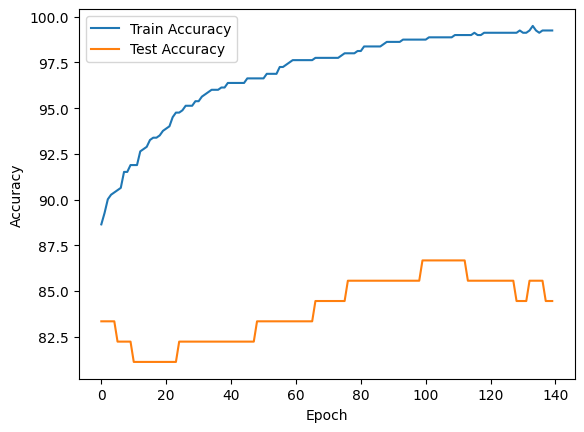

In [119]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

def measure_accuracy(model, input_tensor, label_tensor):
  model.eval()
  output = model(input_tensor)
  _, predicted = torch.max(output.data, 1)
  total = label_tensor.size(0)
  correct = (predicted == label_tensor).sum().item()
  model.train()
  return 100 * correct / total

num_epochs = 140
train_accs = []
test_accs = []
for epoch in range(num_epochs):
  total_loss = 0
  for data, target in train_loader:
    ensemble_model.optimizer.zero_grad()
    output = ensemble_model(data)
    loss = ensemble_model.loss_fn(output, target)
    total_loss += loss.item()
    loss.backward()
    ensemble_model.optimizer.step()

  train_acc = measure_accuracy(ensemble_model, X_train_tensor, y_train_tensor)
  test_acc = measure_accuracy(ensemble_model, X_test_tensor, y_test_tensor)
  train_accs.append(train_acc)
  test_accs.append(test_acc)
  print(f'Train Epoch: {epoch} Loss: {total_loss:.2f}, train-acc: {train_acc:.2f}, test-acc: {test_acc:.2f}')

plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Train Epoch: 0 Loss: 13.91, train-acc: 99.13
Train Epoch: 1 Loss: 14.13, train-acc: 99.13
Train Epoch: 2 Loss: 13.97, train-acc: 99.13
Train Epoch: 3 Loss: 14.12, train-acc: 99.13
Train Epoch: 4 Loss: 13.35, train-acc: 99.13
Train Epoch: 5 Loss: 14.00, train-acc: 99.13
Train Epoch: 6 Loss: 13.31, train-acc: 99.13
Train Epoch: 7 Loss: 12.85, train-acc: 99.13
Train Epoch: 8 Loss: 13.38, train-acc: 99.13
Train Epoch: 9 Loss: 13.21, train-acc: 99.25
Train Epoch: 10 Loss: 12.99, train-acc: 99.25
Train Epoch: 11 Loss: 13.16, train-acc: 99.13
Train Epoch: 12 Loss: 12.70, train-acc: 99.25
Train Epoch: 13 Loss: 13.34, train-acc: 99.38
Train Epoch: 14 Loss: 12.91, train-acc: 99.38
Train Epoch: 15 Loss: 13.15, train-acc: 99.50
Train Epoch: 16 Loss: 12.87, train-acc: 99.63
Train Epoch: 17 Loss: 12.76, train-acc: 99.63
Train Epoch: 18 Loss: 12.47, train-acc: 99.63
Train Epoch: 19 Loss: 12.38, train-acc: 99.63
Train Epoch: 20 Loss: 12.82, train-acc: 99.63
Train Epoch: 21 Loss: 12.71, train-acc: 99.6

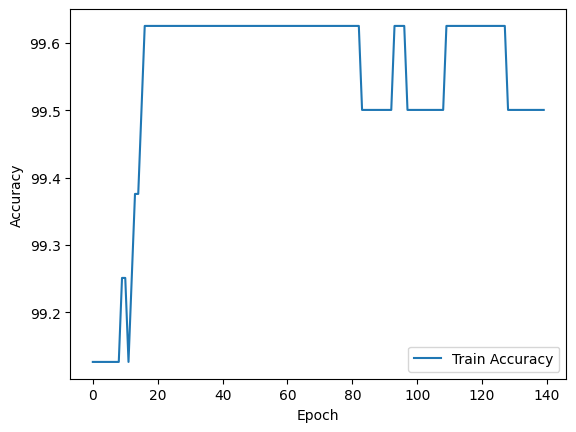

In [120]:
ensemble_model = EnsembleModel([rfc_1, rfc_2, rfc_3, rfc_4], indices)
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.long)

dataset = TensorDataset(X_tensor, y_tensor)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

num_epochs = 140
train_accs = []
for epoch in range(num_epochs):
  total_loss = 0
  for data, target in data_loader:
    ensemble_model.optimizer.zero_grad()
    output = ensemble_model(data)
    loss = ensemble_model.loss_fn(output, target)
    total_loss += loss.item()
    loss.backward()
    ensemble_model.optimizer.step()

  train_acc = measure_accuracy(ensemble_model, X_train_tensor, y_train_tensor)
  train_accs.append(train_acc)
  print(f'Train Epoch: {epoch} Loss: {total_loss:.2f}, train-acc: {train_acc:.2f}')

plt.plot(train_accs, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [153]:
results = pd.DataFrame()
results['PassengerId'] = passengerIds
results['Survived'] = ensemble_model(torch.tensor(unlabeled.values, dtype=torch.float32)).detach().numpy().argmax(1)
results.to_csv('submission.csv', index=False)

In [165]:
results['Survived-rfc1'] = rfc_1.predict(unlabeled[m1_cols])
results['Survived-rfc2'] = rfc_2.predict(unlabeled[m2_cols])
results['Survived-rfc3'] = rfc_3.predict(unlabeled[m3_cols])
results['Survived-rfc4'] = rfc_4.predict(unlabeled[m4_cols])

results['difference'] = (
    (results['Survived-rfc1'] != results['Survived-rfc2']) |
    (results['Survived-rfc1'] != results['Survived-rfc3']) |
    (results['Survived-rfc1'] != results['Survived-rfc4']) |
    (results['Survived-rfc2'] != results['Survived-rfc3']) |
    (results['Survived-rfc2'] != results['Survived-rfc4']) |
    (results['Survived-rfc3'] != results['Survived-rfc4'])
)

results.to_csv('submission.csv', index=False)

Finished